In [27]:















import numpy as np
import pandas as pd
import datetime
from scipy.stats import chi2_contingency,f_oneway
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score



In [13]:
#reading the dataframe 
insurance_df=pd.read_csv('insurance_claims.csv')
insurance_df_copy=insurance_df.copy()
fraud_reported_dict={'Y':1,'N':0}
insurance_df.replace({'fraud_reported':fraud_reported_dict},inplace=True) #replacing all 'Yes' with 1 and 'No' with 0
y=insurance_df['fraud_reported'] #copying output column data into a variable
insurance_df.drop(columns='fraud_reported',inplace=True) #dropping output column.

In [14]:
insurance_df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,1,2,YES,71610,6510,13020,52080,Saab,92x,2004
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,0,?,5070,780,780,3510,Mercedes,E400,2007
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,0,1,NO,6500,1300,650,4550,Accura,RSX,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,0,1,?,87200,17440,8720,61040,Honda,Accord,2006
996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,2,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,0,1,YES,46980,5220,5220,36540,Audi,A5,1998


In [15]:
y

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int64

In [50]:
insurance_df['policy_bind_date']=pd.to_datetime(insurance_df['policy_bind_date'],errors='coerce')
insurance_df['policy_bind_date']
insurance_df['incident_date']=pd.to_datetime(insurance_df['incident_date'],errors='coerce')
insurance_df['incident_date']

0     2015-01-25
1     2015-01-21
2     2015-02-22
3     2015-10-01
4     2015-02-17
         ...    
995   2015-02-22
996   2015-01-24
997   2015-01-23
998   2015-02-26
999   2015-02-26
Name: incident_date, Length: 1000, dtype: datetime64[ns]

In [51]:
#correlation check
#CHI-SQUARE test
correlated_columns=[]
for col in insurance_df.columns:
    if insurance_df[col].dtype=='object':
        contigency_table=pd.crosstab(insurance_df[col],y)
        res=chi2_contingency(contigency_table)
        if res[1]<0.05:
            correlated_columns.append(col)

#ANNOVA test
catogories_list=list(insurance_df_copy['fraud_reported'].value_counts().index)
con_col_aftrdropng=[col for col in insurance_df.columns if insurance_df[col].dtype=='int64' or insurance_df[col].dtype=='float64']
insurance_df['policy_bind_date']=pd.to_datetime(insurance_df['policy_bind_date'],errors='coerce')
for col in con_col_aftrdropng:    
    result=f_oneway(*(insurance_df_copy[insurance_df_copy['fraud_reported']==category][col] for category in catogories_list))
    if result[1]<0.05:
        correlated_columns.append(col)
corr_df=insurance_df[correlated_columns]


In [53]:
insurance_df.isnull().sum()
insurance_df.dtypes

months_as_customer                      int64
age                                     int64
policy_number                           int64
policy_bind_date               datetime64[ns]
policy_state                           object
policy_csl                             object
policy_deductable                       int64
policy_annual_premium                 float64
umbrella_limit                          int64
insured_zip                             int64
insured_sex                            object
insured_education_level                object
insured_occupation                     object
insured_hobbies                        object
insured_relationship                   object
capital-gains                           int64
capital-loss                            int64
incident_date                  datetime64[ns]
incident_type                          object
collision_type                         object
incident_severity                      object
authorities_contacted             

In [54]:
#train-test-split
x_train,x_test,y_train,y_test=train_test_split(corr_df,y,test_size=0.2,random_state=42)

In [55]:
#scaling the continuous variables
scaler=StandardScaler()
con_cols=[col for col in x_train.columns if x_train[col].dtype=='int64' or x_train[col].dtype=='float64']
for col in con_cols:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))


In [56]:
#one-hot coding for categorical variables
oe_train=pd.get_dummies(x_train[[col for col in x_train.columns if x_train[col].dtype=='object']])
oe_test=pd.get_dummies(x_test[[col for col in x_test.columns if x_test[col].dtype=='object']])
oe_train_final,oe_test_final=oe_train.align(oe_test,join='inner',axis=1)
#oe_train_final

In [57]:
#getting final train and test inputs.
x_train_final=pd.concat([x_train[con_cols],oe_train_final],axis=1)
x_test_final=pd.concat([x_test[con_cols],oe_test_final],axis=1)

In [58]:
#Training the model
logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)

LogisticRegression()

In [59]:
#getting predictions on test inputs
pred=logreg.predict(x_test_final)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0], dtype=int64)

In [60]:
#getting prediction probabilities
probabilities=logreg.predict_proba(x_test_final)
pos_prob=probabilities[::,1]
pos_prob

array([0.04591681, 0.04810655, 0.04368781, 0.06491695, 0.13224005,
       0.04459907, 0.23066277, 0.43236418, 0.03892717, 0.08334918,
       0.0104904 , 0.01187215, 0.08829362, 0.66464456, 0.62046272,
       0.03241877, 0.0299653 , 0.39484958, 0.63613099, 0.6118208 ,
       0.03403   , 0.00714687, 0.0436716 , 0.03034469, 0.06744454,
       0.01219519, 0.38533262, 0.03470355, 0.04198698, 0.07624049,
       0.06721215, 0.10295067, 0.09356549, 0.02174779, 0.60429656,
       0.65583219, 0.0707241 , 0.03639239, 0.05780555, 0.02355807,
       0.61500838, 0.61769343, 0.12199478, 0.46080791, 0.80923717,
       0.58154075, 0.03853978, 0.0844459 , 0.06843208, 0.00711855,
       0.04764755, 0.16949552, 0.6885375 , 0.08932031, 0.58508165,
       0.49497454, 0.05516529, 0.06427536, 0.06620372, 0.01903338,
       0.0835616 , 0.1338902 , 0.63367596, 0.03413398, 0.06392793,
       0.06833785, 0.06526978, 0.04526027, 0.45029205, 0.04122191,
       0.25231338, 0.0904948 , 0.61932722, 0.04546236, 0.67577

In [61]:
confusion_matrix(y_test,pred)

array([[127,  18],
       [ 19,  36]], dtype=int64)

In [62]:
precision_score(y_test,pred)

0.6666666666666666

In [63]:
recall_score(y_test,pred)

0.6545454545454545

In [64]:
f1_score(y_test,pred)

0.6605504587155963

In [65]:
fpr,tpr,thresholds=roc_curve(y_test,pos_prob) #false positive rate and true positive rate values to plot au_roc curve
fpr,tpr,thresholds

(array([0.        , 0.00689655, 0.00689655, 0.0137931 , 0.0137931 ,
        0.02068966, 0.02068966, 0.03448276, 0.03448276, 0.04827586,
        0.04827586, 0.05517241, 0.05517241, 0.06206897, 0.06206897,
        0.06896552, 0.06896552, 0.07586207, 0.07586207, 0.08275862,
        0.08275862, 0.08965517, 0.08965517, 0.09655172, 0.09655172,
        0.10344828, 0.10344828, 0.11034483, 0.11034483, 0.11724138,
        0.11724138, 0.12413793, 0.12413793, 0.13103448, 0.13103448,
        0.13793103, 0.13793103, 0.15172414, 0.15172414, 0.16551724,
        0.16551724, 0.60689655, 0.60689655, 0.6137931 , 0.6137931 ,
        0.76551724, 0.76551724, 0.7862069 , 0.7862069 , 0.84137931,
        0.84137931, 1.        , 1.        ]),
 array([0.        , 0.        , 0.01818182, 0.01818182, 0.03636364,
        0.03636364, 0.05454545, 0.05454545, 0.09090909, 0.09090909,
        0.14545455, 0.14545455, 0.25454545, 0.25454545, 0.29090909,
        0.29090909, 0.30909091, 0.30909091, 0.34545455, 0.34545455,
  

Text(0, 0.5, 'True positive rate')

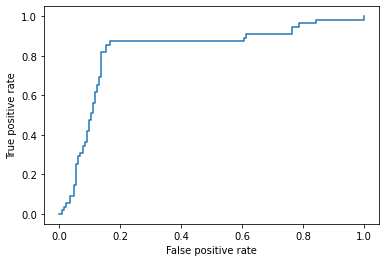

In [66]:
plt.plot(fpr,tpr) #auc_roc curve plot
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [67]:
roc_auc_score(y_test,pred) #calculating area under curve

0.7652037617554859